<a href="https://colab.research.google.com/github/gaurishankar9793/Qr-code-Extraction-/blob/master/Qrcode_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/fernandovr89/off_datatest.git
!git clone https://github.com/gaurishankar9793/Qr-code-Extraction-.git

Cloning into 'off_datatest'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 9), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.
Cloning into 'Qr-code-Extraction-'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [0]:
import os
os.chdir('/content/Qr-code-Extraction-/')

In [24]:
!mv ./Imagehandler.py ./Imagehandler.bk
!mv ./PatternFinding.py ./PatternFinding.bk

mv: cannot stat './Imagehandler.py': No such file or directory
mv: cannot stat './PatternFinding.py': No such file or directory


In [0]:
import sys
import cv2 as cv
import numpy as np


class PatternFinding(object):
    def __init__(self, contours_group, image):
        self.image = image
        if not contours_group:
            print ('Please provide contours')
        else:
            thresholdImage, contours, hierarchy = contours_group
            self.Contours = contours
            self.ThresholdImage = thresholdImage
            self.Hierarchy = hierarchy

    def CheckContourWithinContourHavingLevel(self, nooflevels):
        """This function checks whether there is contour inside another
        contour till level as mentioned in the nooflevels"""
        patterns = []
        patterns_indices = []
        for index in range(len(self.Contours)):
            IsPattern = self.IsPossibleQRContour(index, nooflevels)
            if IsPattern is True:
                patterns.append(self.Contours[index])
                # print self.Contours[index]
                patterns_indices.append(index)
                # patterns_dictionary[hash(tuple(self.Contours[index]))]=index
        #cv.waitKey(0)
        return patterns, patterns_indices

    def FindingQRPatterns(self, nooflevels):
        """This function filters to have only three QR patterns"""
        patterns, patterns_dictionary = self.CheckContourWithinContourHavingLevel(nooflevels)  #returns contours and list of indices
                                                                   #of the returned contours
        QRPatterns = []

        while len(patterns) < 3:
            nooflevels = nooflevels-1
            patterns, patterns_dictionary = \
                self.CheckContourWithinContourHavingLevel(nooflevels)

        if len(patterns) == 3:
            print ('patterns are less than equal to three')
            for ind in range(len(patterns)):
                x, y, w, h = cv.boundingRect(patterns[ind])
                cv.rectangle(
                    self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                #cv.imshow('qr box found', self.image)              #uncomment to debug
                #cv.waitKey(0)
                #cv.destroyAllWindows()
            return patterns
        else:
            area_patterns = np.array(
                [cv.contourArea(pattern) for pattern in patterns])
            arg_areapatterns = np.argsort(area_patterns)
            passage_dictinary = {}
            for i in range(len(patterns)):                 #pick the largest area contour
                index = patterns_dictionary[arg_areapatterns[
                    len(arg_areapatterns) - i - 1]]
                if not index:
                    print ('contour not found in the dictionary')
                else:
                    # print 'papa is', self.Hierarchy[0][index][3]
                    if self.Hierarchy[0][index][3] == -1:
                        passage_dictinary[index] = -1
                    else:
                        if self.IsparentAlreadyThere(passage_dictinary, index):
                            passage_dictinary[index] = 1
                            # print 'got one',self.Hierarchy[0][index][3]
                        else:
                            passage_dictinary[index] = -1

        for ind in range(len(patterns)):
            mapping = patterns_dictionary[ind]
            if passage_dictinary[mapping] == -1:
                x, y, w, h = cv.boundingRect(self.Contours[mapping])
                cv.rectangle(
                    self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                #cv.imshow('contour of qr', self.image)         #uncomment to debug
                #cv.waitKey(0)
                QRPatterns.append(patterns[ind])
                #cv.destroyAllWindows()
        if len(QRPatterns) > 3:
            QRPatterns_new = []
            area_patterns = np.array([
                cv.contourArea(QRpattern) for QRpattern in QRPatterns])
            arg_areapatterns = np.argsort(area_patterns)
            for i in range(3):                     #pick the best three
                QRPatterns_new.append(QRPatterns[arg_areapatterns[
                    len(arg_areapatterns) - i - 1]])
                x, y, w, h = cv.boundingRect(QRPatterns_new[i])
                cv.rectangle(
                    self.image, (x, y), (x + w, y + h), (0, 0, 255), 2)
                #cv.imshow('best qr contour', self.image)           #uncomment to debug
                #cv.waitKey(0)
                #cv.destroyAllWindows()
            QRPatterns = QRPatterns_new
        return QRPatterns

    def IsparentAlreadyThere(self, passage_dictinary, index): #Checks if Parent exists which is present in
        parent = self.Hierarchy[0][index][3]                  #passage_dictionary
        while (parent != -1) and (parent not in passage_dictinary.keys()):
            parent = self.Hierarchy[0][parent][3]

        return not (parent == -1)

    def CheckingRatioOfContours(self, index):
        """This Functions checks whether contours are in the certain ratio
        or not.This is required for qr as the qr has the contours in the
        specific ratio"""
        firstchildindex = self.Hierarchy[0][index][2]
        secondchildindex = self.Hierarchy[0][firstchildindex][2]
        areaoffirst = cv.contourArea(self.Contours[index]) / (
            cv.contourArea(self.Contours[firstchildindex]) + 1e-5)
        areaofsecondchild = cv.contourArea(self.Contours[firstchildindex]) / (
            cv.contourArea(self.Contours[secondchildindex]) + 1e-5)

        # x,y,w,h=cv.boundingRect(self.Contours[firstchildindex])
        # cv.rectangle(self.image,(x,y),(x+w,y+h),(0,0,255),2)
        # x,y,w,h=cv.boundingRect(self.Contours[index])
        # cv.rectangle(self.image,(x,y),(x+w,y+h),(0,0,255),2)
        # x,y,w,h=cv.boundingRect(self.Contours[secondchildindex])
        # cv.rectangle(self.image,(x,y),(x+w,y+h),(0,0,255),2)
       
        # print (areaoffirst/areaofsecondchild)

        return ((areaoffirst / (areaofsecondchild + 1e-5)) > 1 and \
           ((areaoffirst / (areaofsecondchild + 1e-5)) < 10))

    def FindingPatterns(self):
        pass

    def __isContourBInsideContourA(self, contourindexa, contourindexb, heir):
        index = contourindexa
        while heir[0, index, 3] != contourindexb:
            t = heir[0, index, 3]
            if t == -1:
                return False
            index = t
        return False

    def IsPossibleQRContour(self, contourindex, nooflevels):
        """since contours belonging to QR have 6 other contours
        inside it.It is because every border is counted as
        contour in the Opencv"""
        tempContourChild = self.Hierarchy[0][contourindex][2]

        level = 0
        while tempContourChild != -1:
            level = level+1
            tempContourChild = self.Hierarchy[0][tempContourChild][2]

        if (level >= nooflevels):
            #print(level)
           
            IsAreaSame = self.CheckingRatioOfContours(contourindex)
            return (IsAreaSame is True)
        else:
            return False

    def __compareContourArea(self, contourindexa, contourindexb, contours):
        if cv.contourArea(contours[contourindexa]) > \
           cv.contourArea(contours[contourindexb]):
            return True
        else:
            return False

    def LimitContourNumbers(self, minPix, maxPix, contours):
        contours = [contours.remove(contour) for contour in contours if
                    ((cv.contourArea(contour) < minPix) or
                     (cv.contourArea(contour) > maxPix))]

        return contours

    def reduceImageContour(self):
        # contours = self.GetImageContour()
      self.GetImageContour()

In [0]:
# -*- coding: utf-8 -*-
#from PatternFinding import PatternFinding
from FindingOrientationOfContours import FindingOrientationOfContours
from AffineTransformation import AffineTransformation
#import numpy as np

import cv2 as cv
import os.path
#print("i am here")

class Imagehandler(object):
    def __init__(self, image):
            self.Image = image
            
                
        

    def __convertImagetoBlackWhite(self):
        self.imageOriginal = self.Image
        if self.Image is None:
            print ('some problem with the image')
        else:
            print ('Image Loaded')

        self.Image = cv.cvtColor(self.Image, cv.COLOR_BGR2GRAY)
        self.Image = cv.adaptiveThreshold(
            self.Image,
            255,                    # Value to assign
            cv.ADAPTIVE_THRESH_MEAN_C,# Mean threshold
            cv.THRESH_BINARY,
            11,                    # Block size of small area
            2# Const to substract
        )

        return self.Image

    

    def GetImageContour(self):
        thresholdImage = self.__convertImagetoBlackWhite()  #B & W with adaptive threshold
        thresholdImage = cv.Canny(thresholdImage, 100, 200) #Edges by canny edge detection
        thresholdImage, contours, hierarchy = cv.findContours(
            thresholdImage, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        self.Contours = contours
         #uncomment this to see the contours on the image
         #cv2.drawContours(thresholdImage, contours, -1, (0,255,0), 3)
         #patternFindingObj=PatternFinding()
         #areas= [cv.contourArea(contour) for contour in contours]
         #for index in xrange(len(contours)):
          #   IsPattern=self.IsPossibleQRContour(index)
           #  if IsPattern is True:
            #     x,y,w,h=cv.boundingRect(contours[index])
             #    cv.rectangle(self.imageOriginal,(x,y),(x+w,y+h),(0,0,255),2)
              #   cv.imshow("hello",self.imageOriginal)
        # maxAreaIndex=np.argmax(areas)
         #x,y,w,h=cv.boundingRect(contours[maxAreaIndex])
         #cv.rectangle(self.image2,(x,y),(x+w,y+h),(0,255,0),2)
         #cv.imshow("hello",self.imageOriginal)
         #cv.waitKey(0)
        #cv.destroyAllWindows()
        contour_group = (thresholdImage, contours, hierarchy)
        return contour_group

    def QRCodeInImage(self):
        patternFindingObj = PatternFinding(
            self.GetImageContour(), self.imageOriginal)
        patterns = patternFindingObj.FindingQRPatterns(3)
        if len(patterns) == 0:
            print ('patterns unable to find')
        contourA = patterns[0]
        contourB = patterns[1]
        contourC = patterns[2]
        orientationObj = FindingOrientationOfContours()
        Right, Bottom, Top = orientationObj.FindOrientation(
            contourA, contourB, contourC)
        #print( Right[0])
        #print (Bottom[0])
        #print (Top[0])
        affineTransformObj = AffineTransformation(self.imageOriginal)
        self.TransformImage = affineTransformObj.Transform(Top, Right, Bottom)
        
        return self.TransformImage

In [0]:
#from Imagehandler import Imagehandler
import yaml
import glob
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

In [0]:
os.chdir('/content/off_datatest/qr_data_noOFF/')

In [29]:
files = [f for f in os.listdir('./') if os.path.isfile(f)]
print(files)

['index05.jpg', 'index00.jpg', 'index03.jpg', 'index01.jpeg', 'index06.jpeg', 'index09.png', 'index07.jpg', 'index08.jpg', 'index04.png', 'index02.jpeg']


---------File: index05.jpg---------


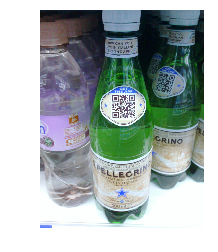

Locking for a QR code...
Image Loaded
-1.0460525627596997 374.41516132190054


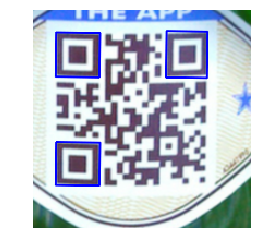

---------File: index00.jpg---------


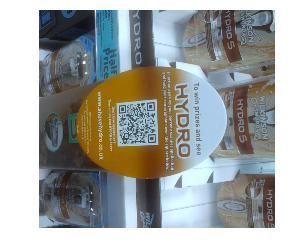

Locking for a QR code...
Image Loaded
5.988371396701 -3089.28291328324


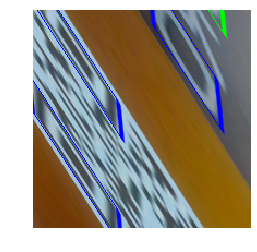

---------File: index03.jpg---------


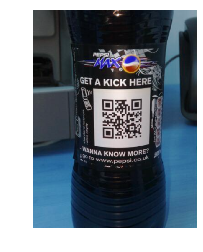

Locking for a QR code...
Image Loaded
-1.0080644348335133 133.76541660500675


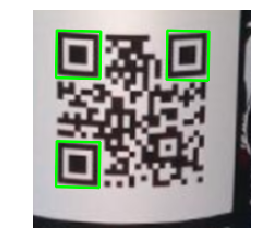

---------File: index01.jpeg---------


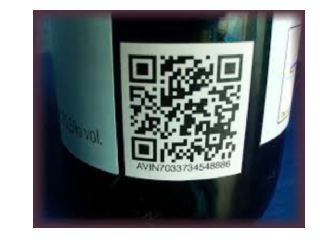

Locking for a QR code...
Image Loaded
-0.9430379149976003 -28.928765126419364


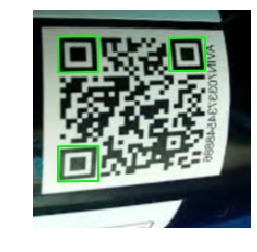

---------File: index06.jpeg---------


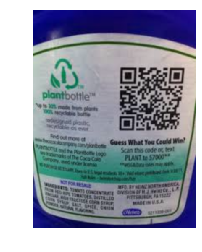

Locking for a QR code...
Image Loaded
-0.9495797521361553 20.72285048467637


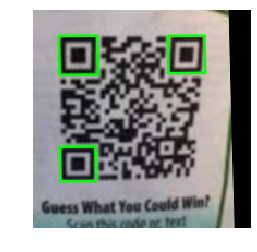

---------File: index09.png---------


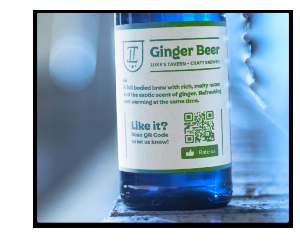

Locking for a QR code...
Image Loaded
This file has an issue during QR detection: index09.png
---------File: index07.jpg---------


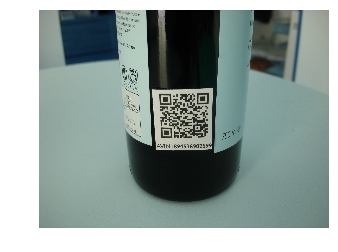

Locking for a QR code...
Image Loaded
0.5998835142697524 208.22342145067654


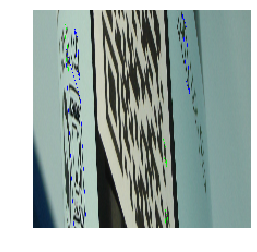

---------File: index08.jpg---------


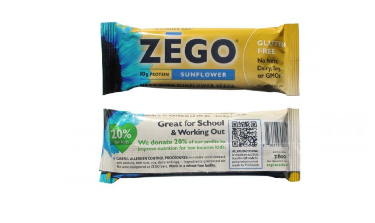

Locking for a QR code...
Image Loaded
This file has an issue during QR detection: index08.jpg
---------File: index04.png---------


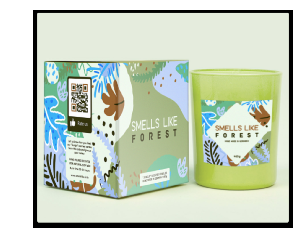

Locking for a QR code...
Image Loaded
This file has an issue during QR detection: index04.png
---------File: index02.jpeg---------


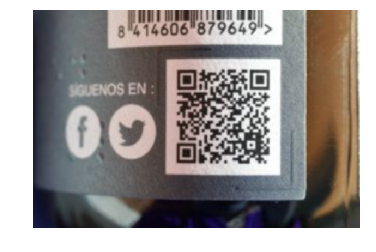

Locking for a QR code...
Image Loaded
-0.9925925190672208 23.42631706649547


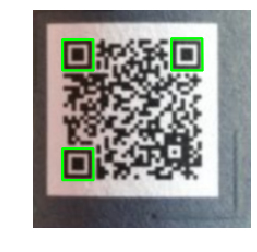

In [30]:
import cv2 as cv
for file in files:
  print('---------File: '+file+'---------')
  image = cv.imread(file)
#cv.imshow('Qr code is ',image)
  src = image
  scale_ratio = 2.0
  image = cv.resize(src, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv.INTER_NEAREST)
  src = image
  image = cv.GaussianBlur(src, (5, 5), 0)
  h,w = image.shape[:2]
  #print(image.shape)
  plt.imshow(image,cmap='gray')
  plt.axis('off')
  plt.show()
  print('Locking for a QR code...')
  try:
    obj = Imagehandler(image)
    TransformImage = obj.QRCodeInImage()
    im = TransformImage
    plt.imshow(im)
    plt.axis('off')
    plt.show()
  except:
    print('This file has an issue during QR detection: '+file)
  